Gene Ontology aided Compound Protein Binding
Affinity Prediction Using Neural Network

In [11]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate # type: ignore
from tensorflow.keras.layers import BatchNormalization # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import ReduceLROnPlateau # type: ignore
from keras.preprocessing.sequence import pad_sequences # type: ignore
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from lifelines.utils import concordance_index
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.metrics import precision_recall_curve, auc

Loading data

In [2]:
df_kiba = pd.read_csv("kiba.txt", header=None,sep = " ", names = ["drug_id", "protein_id", "SMILES_seq_drug", "amino_acid_seq", "affinity_score"])

In [3]:
#check for any missing values in train data
print(df_kiba.isnull().any().sum())
df = df_kiba
df

0


,drug_id,protein_id,SMILES_seq_drug,amino_acid_seq,affinity_score
0,CHEMBL1087421,O00141,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MTVKTEAAKGTLTYSRMRGMVAILIAFMKQRRMGLNDFIQKIANNS...,11.10000
1,CHEMBL1087421,O14920,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQC...,11.10000
2,CHEMBL1087421,O15111,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MERPPGLRPGAGGPWEMRERLGTGGFGNVCLYQHRELDLKIAIKSC...,11.10000
3,CHEMBL1087421,P00533,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,11.10000
4,CHEMBL1087421,P04626,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,11.10000
...,...,...,...,...,...
118249,CHEMBL230654,Q13554,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MATTVTCTRFTDEYQLYEDIGKGAFSVVRRCVKLCTGHEYAAKIIN...,10.49794
118250,CHEMBL230654,Q13555,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MATTATCTRFTDDYQLFEELGKGAFSVVRRCVKKTSTQEYAAKIIN...,10.49794
118251,CHEMBL230654,Q13557,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MASTTTCTRFTDEYQLFEELGKGAFSVVRRCMKIPTGQEYAAKIIN...,10.49794
118252,CHEMBL230654,Q16539,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKT...,10.49794


Using One-Hot encoding for SMILES and AMINO ACIDS sequence

In [4]:
#for amino acid sequence
# Step 1: Extract unique characters from the specified column ('amino_acid_seq')
unique_chars = sorted(set(''.join(df['amino_acid_seq'])))  # Concatenate all strings and find unique characters

# Step 2: Create a mapping for each unique character
char_to_int = {char: idx + 1 for idx, char in enumerate(unique_chars)}  # Map each character to a unique number (starting from 1)

# Step 3: Function to encode a sequence using the generated mapping
def encode_sequence(sequence):
    return [char_to_int.get(aa, 0) for aa in sequence]  # Default to 0 if character is not found

# Step 4: Apply the encoding function to the specified column
df['amino_acid_seq_encoded'] = df['amino_acid_seq'].apply(encode_sequence)

#for SMILES sequence
# Step 1: Extract unique characters from the specified column ('SMILES_seq_drug')
unique_chars = sorted(set(''.join(df['SMILES_seq_drug'])))  # Concatenate all strings and find unique characters

# Step 2: Create a mapping for each unique character
char_to_int = {char: idx + 1 for idx, char in enumerate(unique_chars)}  # Map each character to a unique number (starting from 1)

# Step 3: Function to encode a sequence using the generated mapping
def encode_sequence(sequence):
    return [char_to_int.get(aa, 0) for aa in sequence]  # Default to 0 if character is not found

# Step 4: Apply the encoding function to the specified column
df['SMILES_seq_drug_encoded'] = df['SMILES_seq_drug'].apply(encode_sequence)


Padding the amino acid and smiles sequences with 0's to ensure uniformity

In [5]:
# Step 1: Use pad_sequences to pad the sequences
padded_seqs = pad_sequences(df['amino_acid_seq_encoded'], padding='post', value=0)

# Step 2: Truncate and assign the padded sequences back to the DataFrame
df['aa_seq_padded'] = list(padded_seqs)
max_length = 1000
df['aa_seq_padded'] = df['aa_seq_padded'].apply(lambda x: x[:max_length])

# Step 1: Use pad_sequences to pad the sequences
padded_seqs = pad_sequences(df['SMILES_seq_drug_encoded'], padding='post', value=0)

# Step 2: Truncate and assign the padded sequences back to the DataFrame
df['smiles_seq_padded'] = list(padded_seqs)
max_length = 100
df['smiles_seq_padded'] = df['smiles_seq_padded'].apply(lambda x: x[:max_length])

df

,drug_id,protein_id,SMILES_seq_drug,amino_acid_seq,affinity_score,amino_acid_seq_encoded,SMILES_seq_drug_encoded,aa_seq_padded,smiles_seq_padded
0,CHEMBL1087421,O00141,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MTVKTEAAKGTLTYSRMRGMVAILIAFMKQRRMGLNDFIQKIANNS...,11.10000,"[11, 17, 18, 9, 17, 4, 1, 1, 9, 6, 17, 10, 17,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 17, 18, 9, 17, 4, 1, 1, 9, 6, 17, 10, 17,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ..."
1,CHEMBL1087421,O14920,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQC...,11.10000,"[11, 16, 19, 16, 13, 16, 10, 17, 17, 14, 17, 2...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 16, 19, 16, 13, 16, 10, 17, 17, 14, 17, 2...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ..."
2,CHEMBL1087421,O15111,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MERPPGLRPGAGGPWEMRERLGTGGFGNVCLYQHRELDLKIAIKSC...,11.10000,"[11, 4, 15, 13, 13, 6, 10, 15, 13, 6, 1, 6, 6,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 4, 15, 13, 13, 6, 10, 15, 13, 6, 1, 6, 6,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ..."
3,CHEMBL1087421,P00533,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,11.10000,"[11, 15, 13, 16, 6, 17, 1, 6, 1, 1, 10, 10, 1,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 15, 13, 16, 6, 17, 1, 6, 1, 1, 10, 10, 1,...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ..."
4,CHEMBL1087421,P04626,COC1=C(C=C2C(=C1)CCN=C2C3=CC(=C(C=C3)Cl)Cl)Cl,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,11.10000,"[11, 4, 10, 1, 1, 10, 2, 15, 19, 6, 10, 10, 10...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ...","[11, 4, 10, 1, 1, 10, 2, 15, 19, 6, 10, 10, 10...","[18, 23, 18, 7, 16, 18, 2, 18, 16, 18, 8, 18, ..."
...,...,...,...,...,...,...,...,...,...
118249,CHEMBL230654,Q13554,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MATTVTCTRFTDEYQLYEDIGKGAFSVVRRCVKLCTGHEYAAKIIN...,10.49794,"[11, 1, 17, 17, 18, 17, 2, 17, 15, 5, 17, 3, 4...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 1, 17, 17, 18, 17, 2, 17, 15, 5, 17, 3, 4...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,..."
118250,CHEMBL230654,Q13555,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MATTATCTRFTDDYQLFEELGKGAFSVVRRCVKKTSTQEYAAKIIN...,10.49794,"[11, 1, 17, 17, 1, 17, 2, 17, 15, 5, 17, 3, 3,...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 1, 17, 17, 1, 17, 2, 17, 15, 5, 17, 3, 3,...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,..."
118251,CHEMBL230654,Q13557,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MASTTTCTRFTDEYQLFEELGKGAFSVVRRCMKIPTGQEYAAKIIN...,10.49794,"[11, 1, 16, 17, 17, 17, 2, 17, 15, 5, 17, 3, 4...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 1, 16, 17, 17, 17, 2, 17, 15, 5, 17, 3, 4...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,..."
118252,CHEMBL230654,Q16539,CCCC1=C(NC=N1)CNC2=CC(=C3C(=C2)C(=C(C=N3)C#N)N...,MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKT...,10.49794,"[11, 16, 14, 4, 15, 13, 17, 5, 20, 15, 14, 4, ...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,...","[11, 16, 14, 4, 15, 13, 17, 5, 20, 15, 14, 4, ...","[18, 18, 18, 18, 7, 16, 18, 2, 22, 18, 16, 22,..."


Train-test splitting – Case 2
New proteins in test:
90% proteins are present in the train, with all their drug interactions and remaining proteins with all their interactions are present in test



In [7]:

# Separate proteins into training and test sets (90% for training, 10% for testing)
train_proteins, test_proteins = train_test_split(df['protein_id'].unique(), test_size=0.1, random_state=42)

# Now we can create a train and test dataset by filtering the DataFrame based on the protein ids
train_df = df[df['protein_id'].isin(train_proteins)]
test_df = df[df['protein_id'].isin(test_proteins)]

# Shuffle the final train and test data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)


Checking whether the split happened properly

In [8]:
print(train_df.shape)
print(test_df.shape)

train_list = train_df['protein_id'].unique()
test_list = test_df['protein_id'].unique()

for i in test_list:
    if(i in train_list): print("Error")
else: print("Split performed correctly")

(107704, 9)
(10550, 9)
Split performed correctly


Building the Convolutional Neural Network

In [29]:
# Define the first neural network (Model 1)
input1 = Input(shape=(1000,))
x1 = Dense(250, activation='relu')(input1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(80, activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)

x1 = Dense(20, activation='relu')(x1)
x1 = BatchNormalization()(x1)

# Define the second neural network (Model 2)
input2 = Input(shape=(100,))
x2 = Dense(50, activation='relu')(input2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.1)(x2)

x2 = Dense(16, activation='relu')(x2)
x2 = BatchNormalization()(x2)

# Concatenate the outputs of the two models
concatenated = Concatenate()([x1, x2])

# Further layers after concatenation
x = Dense(16, activation='relu')(concatenated)
x = Dense(4, activation='relu')(x)

# Output layer
output = Dense(1, activation='linear')(x)

# Define the combined model using the Functional API
model = Model(inputs=[input1, input2], outputs=output)

Compiling the model

In [30]:
#Optimizer
optimizer = Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999 )

#Compiling the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 250)       │    250,250 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250)       │      1,000 │ dense_24[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 250)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 80)        │     20,080 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 50)        │      5,050 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80)        │        320 │ dense_25[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50)        │        200 │ dense_27[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 80)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 50)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 20)        │      1,620 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 16)        │        816 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20)        │         80 │ dense_26[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16)        │         64 │ dense_28[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 36)        │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 16)        │        592 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 4)         │         68 │ dense_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 1)         │          5 │ dense_30[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 280,145 (1.07 MB)

 Trainable params: 279,313 (1.07 MB)

 Non-trainable params: 832 (3.25 KB)

Training the model

In [31]:
aa_seq = pad_sequences(train_df['aa_seq_padded'], padding='post', dtype='int8')
smiles_seq = pad_sequences(train_df['smiles_seq_padded'], padding='post', dtype='int8')
x_train = [aa_seq, smiles_seq]
y_train = train_df['affinity_score']

aa_seq = pad_sequences(test_df['aa_seq_padded'], padding='post', dtype='int8')
smiles_seq = pad_sequences(test_df['smiles_seq_padded'], padding='post', dtype='int8')
x_test = [aa_seq, smiles_seq]
y_test = test_df['affinity_score']

batch_size = 2000
epochs = 30

customLR = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.7, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=0.0001, 
)

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs, 
                    validation_data = (x_test, y_test), verbose=1, callbacks = [customLR, early_stopping])

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 30.0762 - mae: 3.9140 - val_loss: 476.8213 - val_mae: 16.6140 - learning_rate: 0.0500
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.7828 - mae: 0.6428 - val_loss: 11.7103 - val_mae: 2.7398 - learning_rate: 0.0500
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.7099 - mae: 0.6123 - val_loss: 1.4011 - val_mae: 0.9177 - learning_rate: 0.0500
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.6956 - mae: 0.6096 - val_loss: 0.7315 - val_mae: 0.6470 - learning_rate: 0.0500
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.6371 - mae: 0.5704 - val_loss: 0.7258 - val_mae: 0.6532 - learning_rate: 0.0500
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.6600 - mae: 0.5887 - val_loss: 0.5869 - val_mae: 0.5479 - learning_rate: 0.0500
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.6142 - mae: 0.5598 - val_loss: 0.5828 - val_mae: 0.5281 - learning_rate: 0.0500
Epoch 8

Evaluating the Model

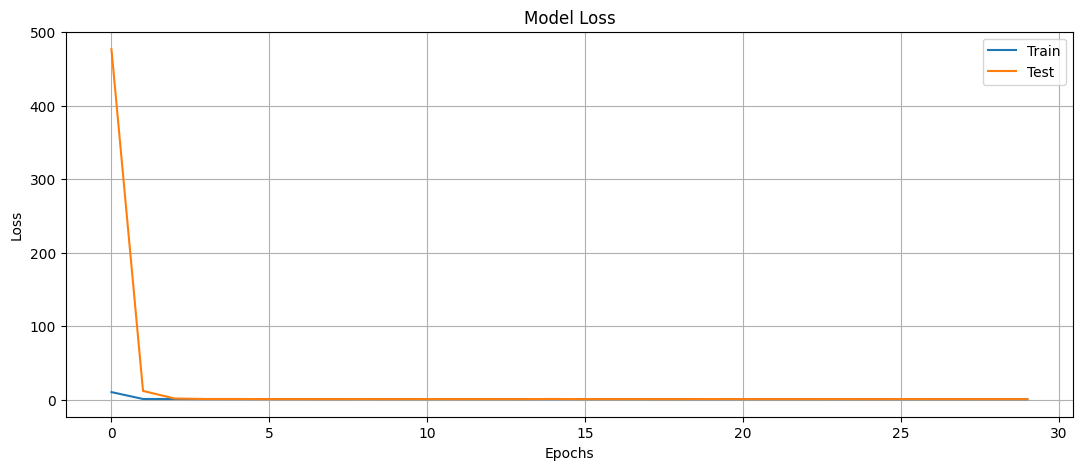

In [32]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

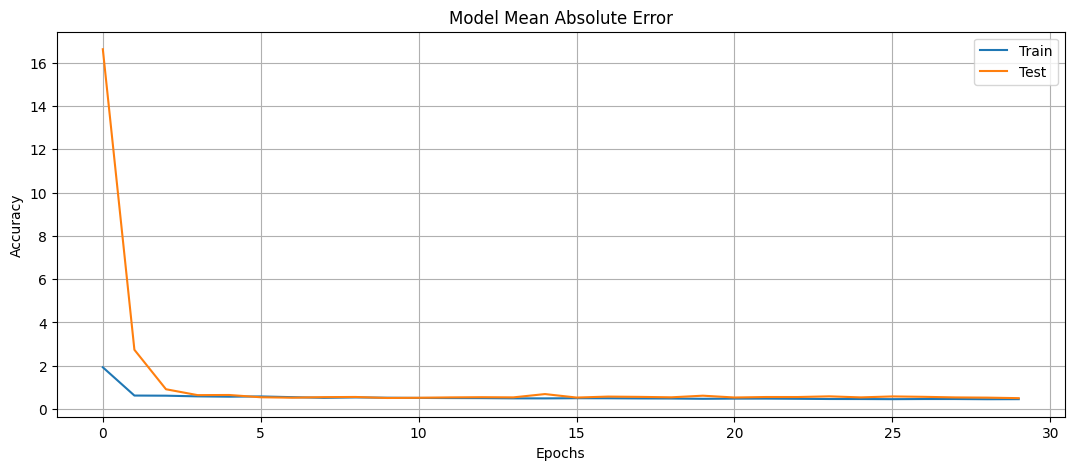

In [33]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

Since the validation_accuracy and the accuracy are really close together we can conclude that we are not overfitting the data.

Measuring the performance of model

In [34]:
y_pred = model.predict(x_test).flatten()

330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [35]:
# Looking at the predictions
for i in range(len(y_pred)):
    print("actual: ", y_test[i], "predicted: ", y_pred[i])

actual:  12.199999035 predicted:  11.713448
actual:  11.400000202 predicted:  11.3521805
actual:  11.900000875 predicted:  11.372
actual:  11.800000504 predicted:  12.129299
actual:  11.400000202 predicted:  11.497802
actual:  10.622878745 predicted:  10.604365
actual:  11.1 predicted:  11.443655
actual:  11.1 predicted:  11.341216
actual:  11.1 predicted:  11.498881
actual:  11.699999383 predicted:  11.364704
actual:  11.1 predicted:  11.579275
actual:  11.1 predicted:  11.537564
actual:  10.1 predicted:  11.271927
actual:  11.1 predicted:  11.671937
actual:  11.200000128 predicted:  11.495915
actual:  12.699997654 predicted:  11.962255
actual:  11.1 predicted:  11.794597
actual:  11.999998417 predicted:  11.833967
actual:  11.900000875 predicted:  11.457323
actual:  11.1 predicted:  12.413785
actual:  11.1 predicted:  11.310572
actual:  11.1 predicted:  11.7003
actual:  11.200000128 predicted:  11.701833
actual:  12.1 predicted:  11.578317
actual:  11.200000128 predicted:  11.913749


In [36]:

# Calculate the C-Index
ci = concordance_index(y_test, y_pred)
print("concordance index: " , ci)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("mean_squared_error: ", mse)

# Calculate pearson correlation
pearson_corr, p_value = pearsonr(y_test, y_pred)
print("pearson correlation: ", pearson_corr)

concordance index:  0.6656431222370347
mean_squared_error:  0.5135270680275437
pearson correlation:  0.5088079925068345
